### Feature Engineering: Based on Time and Chemical Engineering

In [22]:
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar

def load_cleaned_dataframe(file_name):
    """Load the cleaned DataFrame from a CSV file."""
    df_cleaned = pd.read_csv(file_name, index_col=0, parse_dates=True)
    print(f"DataFrame loaded from {file_name}")
    
    # Reset the index to include the timestamp as a regular column
    df_cleaned.reset_index(inplace=True)
    
    # Drop the "index" column if it exists
    if 'index' in df_cleaned.columns:
        df_cleaned.drop(columns=['index'], inplace=True)
    
    return df_cleaned

def calculate_time_based_features(df):
    """Calculate time-based features from the timestamp."""
    
    # Year
    df['year'] = df['timestamp'].dt.year
    
    # Month (1 to 12)
    df['month'] = df['timestamp'].dt.month
    
    # Day of the Month (1 to 31)
    df['day'] = df['timestamp'].dt.day
    
    # Day of the Week (1 to 7, where 1=Monday and 7=Sunday)
    df['day_of_week'] = df['timestamp'].dt.isocalendar().day
    
    # Weekday (True for weekdays, False for weekends)
    df['weekday'] = df['timestamp'].dt.weekday < 5
    
    # Holidays (True if the date is a holiday, False otherwise)
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=df['timestamp'].min(), end=df['timestamp'].max())
    df['holiday'] = df['timestamp'].isin(holidays)
    
    # Hour (0 to 23)
    df['hour'] = df['timestamp'].dt.hour
    
    # Part of Day (categorizing hours)
    df['part_of_day'] = df['hour'].apply(categorize_hour)
    
    # Is Month Start or End
    df['month_start'] = df['timestamp'].dt.is_month_start
    df['month_end'] = df['timestamp'].dt.is_month_end
    
    # Is Quarter Start or End
    df['quarter_start'] = df['timestamp'].dt.is_quarter_start
    df['quarter_end'] = df['timestamp'].dt.is_quarter_end
    
    # Day of Year (1 to 365 or 366)
    df['day_of_year'] = df['timestamp'].dt.dayofyear

    return df

def categorize_hour(hour):
    """Categorize hour into part of day."""
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

def calculate_features(df):
    """Calculate new features from temperature, humidity, and time-based features."""
    
    # Calculate time-based features
    df = calculate_time_based_features(df)

    # Dimensionless Numbers
    df['THI'] = calculate_thi(df['temperature'], df['humidity'])
    df['enthalpy'] = calculate_enthalpy(df['temperature'], df['humidity'])

    # Relative Humidity (if needed as a feature separately)
    df['relative_humidity'] = df['humidity']  # Assuming humidity column is already relative humidity

    # Dew Point Calculation
    df['dew_point'] = df.apply(lambda row: calculate_dew_point(row['temperature'], row['humidity']), axis=1)

    # Lagging Variables
    for lag in range(1, 6):
        df[f'temperature_lag_{lag}'] = df['temperature'].shift(lag)
        df[f'humidity_lag_{lag}'] = df['humidity'].shift(lag)
    
    # Rolling Averages
    df['temperature_rolling_3'] = df['temperature'].rolling(window=3).mean()
    df['humidity_rolling_3'] = df['humidity'].rolling(window=3).mean()
    
    # Exponential Moving Averages (EMA)
    df['temperature_ema_3'] = df['temperature'].ewm(span=3, adjust=False).mean()
    df['humidity_ema_3'] = df['humidity'].ewm(span=3, adjust=False).mean()

    # Rate of Change
    df['temp_rate_of_change'] = df['temperature'].diff()
    df['humidity_rate_of_change'] = df['humidity'].diff()

    # Interaction Features
    df['temp_humidity_interaction'] = df['temperature'] * df['humidity']
    df['temperature_squared'] = df['temperature'] ** 2
    df['humidity_squared'] = df['humidity'] ** 2

    # Psychrometric Properties
    df['wet_bulb_temperature'] = df.apply(lambda row: calculate_wet_bulb_temperature(row['temperature'], row['humidity']), axis=1)
    df['specific_humidity'] = df.apply(lambda row: calculate_specific_humidity(row['temperature'], row['humidity']), axis=1)

    # Cumulative Features
    base_temperature = 18  # Adjust this base temperature as needed (e.g., 18°C or 65°F)
    df['HDD'] = df.apply(lambda row: calculate_hdd(row['temperature'], base_temperature), axis=1).cumsum()
    df['CDD'] = df.apply(lambda row: calculate_cdd(row['temperature'], base_temperature), axis=1).cumsum()

    return df

def calculate_thi(temperature, humidity):
    """Calculate the Temperature-Humidity Index (THI)."""
    THI = temperature - ((0.55 - 0.0055 * humidity) * (temperature - 14.5))
    return THI

def calculate_enthalpy(temperature, humidity):
    """Calculate the enthalpy based on temperature and relative humidity."""
    T_kelvin = temperature + 273.15  # Convert temperature to Kelvin
    RH = humidity / 100.0  # Convert percentage to a fraction
    pressure = 1013.25  # Standard atmospheric pressure in hPa
    es = 6.11 * 10.0**((7.5 * temperature) / (237.3 + temperature))  # Saturation vapor pressure
    e = RH * es  # Actual vapor pressure
    w = 0.622 * e / (pressure - e)  # Mixing ratio
    enthalpy = 1.006 * temperature + w * (2501 + 1.86 * temperature)  # Enthalpy in kJ/kg
    return enthalpy

def calculate_dew_point(temperature, humidity):
    """Calculate the dew point based on temperature and relative humidity."""
    a = 17.27
    b = 237.7
    alpha = ((a * temperature) / (b + temperature)) + np.log(humidity / 100.0)
    dew_point = (b * alpha) / (a - alpha)
    return dew_point

def calculate_wet_bulb_temperature(temperature, humidity):
    """Calculate the Wet-Bulb Temperature based on temperature and relative humidity."""
    Tw = temperature * np.arctan(0.151977 * np.sqrt(humidity + 8.313659)) + \
         np.arctan(temperature + humidity) - \
         np.arctan(humidity - 1.676331) + \
         0.00391838 * humidity**(3/2) * np.arctan(0.023101 * humidity) - 4.686035
    return Tw

def calculate_specific_humidity(temperature, humidity):
    """Calculate Specific Humidity based on temperature and relative humidity."""
    es = 6.11 * 10.0**((7.5 * temperature) / (237.3 + temperature))  # Saturation vapor pressure
    e = (humidity / 100) * es  # Actual vapor pressure
    specific_humidity = 0.622 * e / (1013.25 - e)  # Specific Humidity in kg/kg
    return specific_humidity

def calculate_hdd(temperature, base_temp):
    """Calculate Heating Degree Days (HDD)."""
    return max(base_temp - temperature, 0)

def calculate_cdd(temperature, base_temp):
    """Calculate Cooling Degree Days (CDD)."""
    return max(temperature - base_temp, 0)

def main():
    # Load the cleaned DataFrame back into memory for feature engineering
    df = load_cleaned_dataframe('df_cleaned.csv')
    
    # Apply feature engineering
    df = calculate_features(df)
    
    # Drop NaN values
    df = df.dropna()
    
    # Save the feature-engineered DataFrame to a CSV file
    df.to_csv('df_feature_eng.csv', index=False)
    
    # # Show the first few rows of the DataFrame after feature engineering (transposed for easier reading)
    # print("\nFirst few rows of the DataFrame after feature engineering (transposed):")
    # display(df.head().transpose())
    
    # Display DataFrame info
    print("\nDataFrame Info:")
    display(df.info())

if __name__ == "__main__":
    main()


DataFrame loaded from df_cleaned.csv

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 716 entries, 5 to 720
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   timestamp                  716 non-null    datetime64[ns]
 1   temperature                716 non-null    float64       
 2   humidity                   716 non-null    float64       
 3   energy_consumption         716 non-null    float64       
 4   year                       716 non-null    int32         
 5   month                      716 non-null    int32         
 6   day                        716 non-null    int32         
 7   day_of_week                716 non-null    UInt32        
 8   weekday                    716 non-null    bool          
 9   holiday                    716 non-null    bool          
 10  hour                       716 non-null    int32         
 11  part_of_day           

None

### Visualize the Data

DataFrame loaded from df_feature_eng.csv


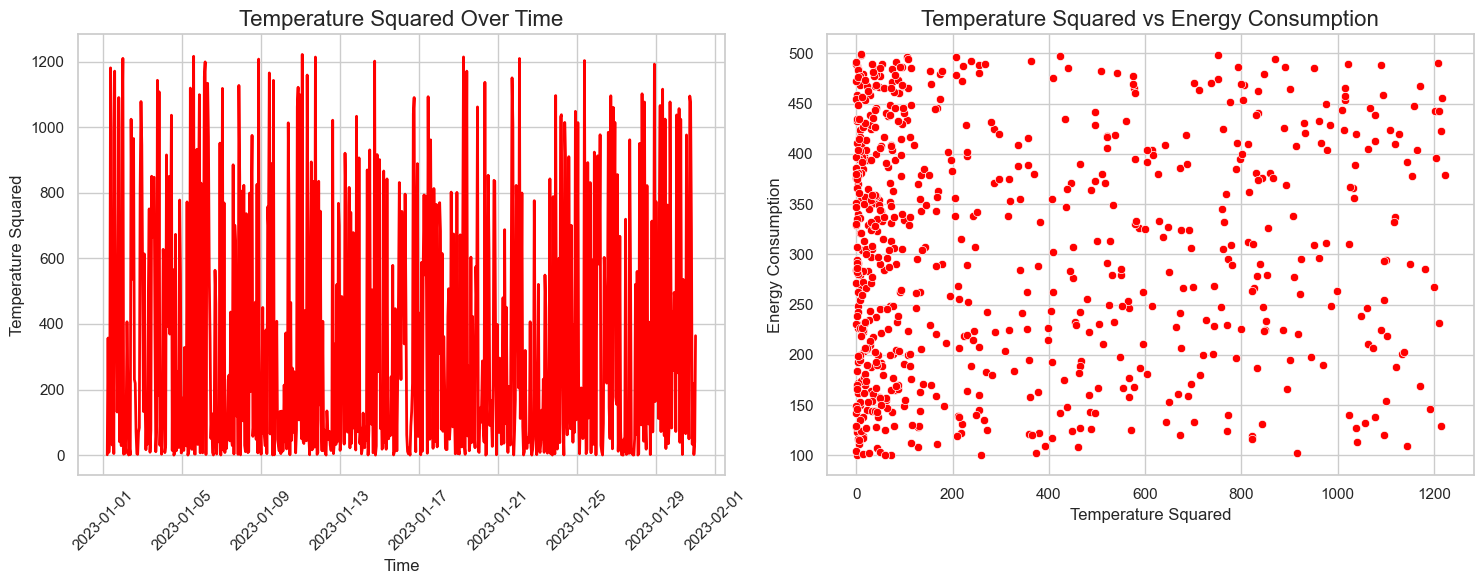

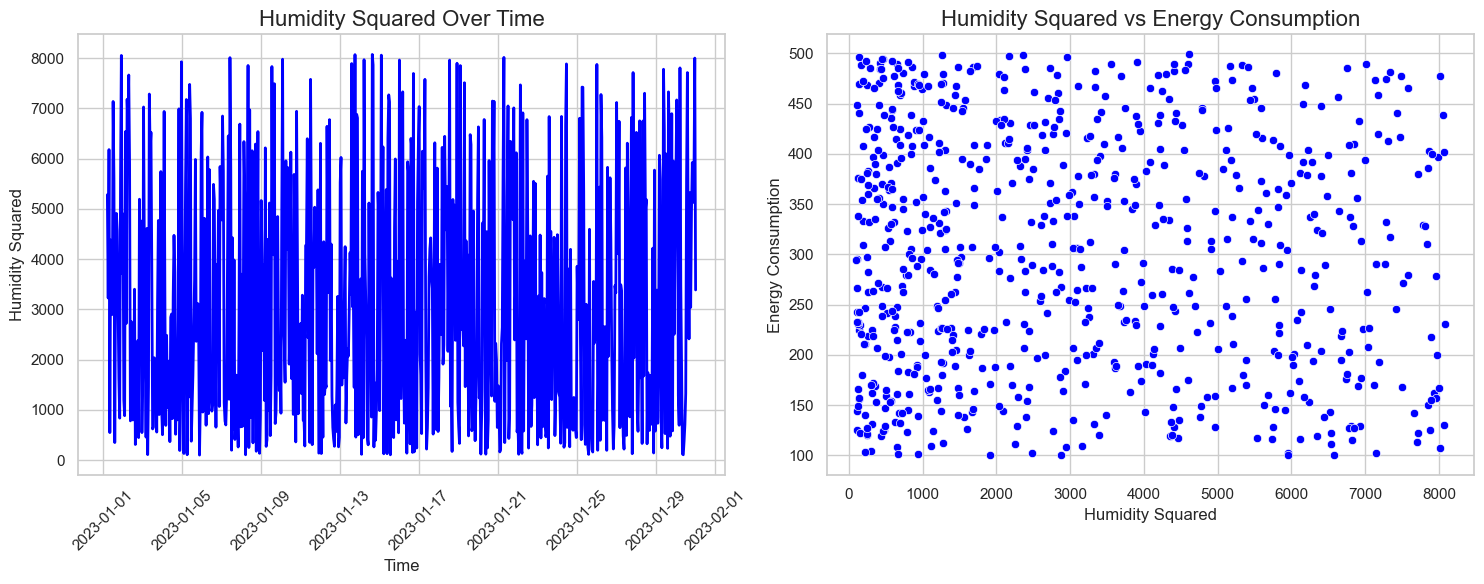

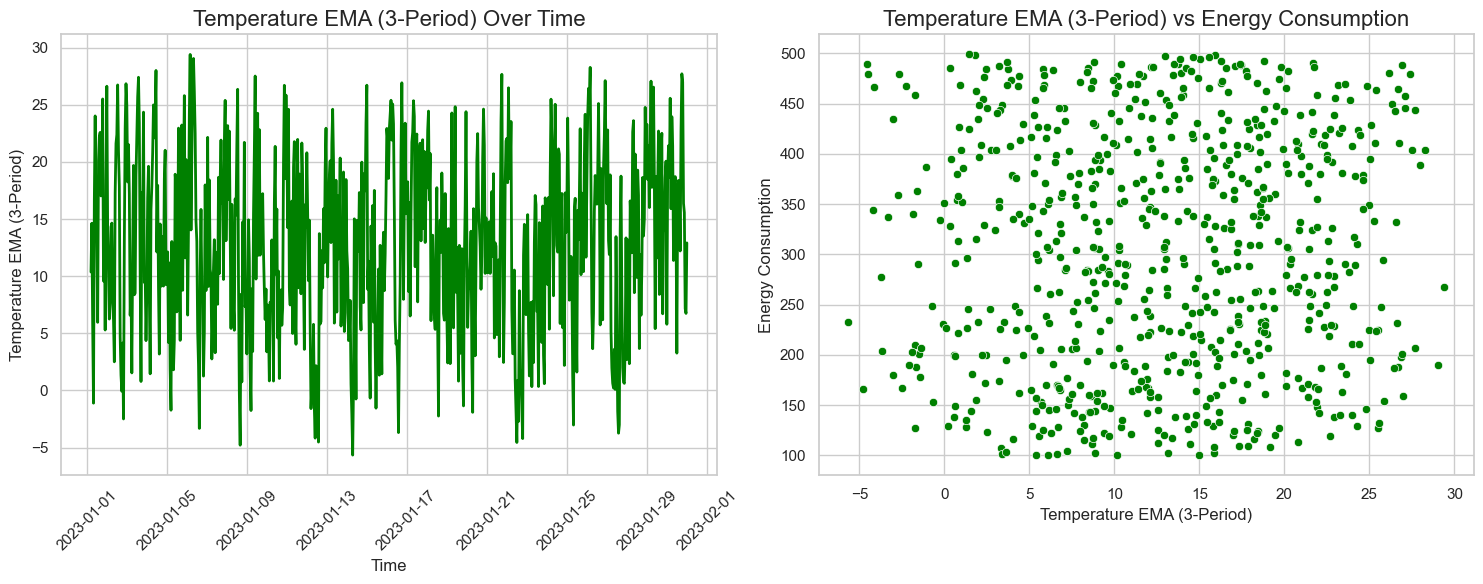

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def load_feature_eng_dataframe(file_name):
    """Load the feature-engineered DataFrame from a CSV file."""
    df_feature_eng = pd.read_csv(file_name, index_col=0, parse_dates=True)
    print(f"DataFrame loaded from {file_name}")
    
    # Reset the index to include the timestamp as a regular column and rename it
    df_feature_eng.reset_index(inplace=True)
    df_feature_eng.rename(columns={'index': 'timestamp'}, inplace=True)  # Rename index column
    
    return df_feature_eng

def plot_side_by_side(df, feature, color, title):
    """Plot side-by-side line and scatter plots for a given feature and energy consumption."""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Line plot for the feature over time
    sns.lineplot(x='timestamp', y=feature, data=df, color=color, lw=2, ax=axes[0])
    axes[0].set_title(f'{title} Over Time', fontsize=16)
    axes[0].set_xlabel('Time', fontsize=12)
    axes[0].set_ylabel(f'{title}', fontsize=12)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Scatter plot for the feature vs energy consumption
    sns.scatterplot(x=feature, y='energy_consumption', data=df, color=color, ax=axes[1])
    axes[1].set_title(f'{title} vs Energy Consumption', fontsize=16)
    axes[1].set_xlabel(f'{title}', fontsize=12)
    axes[1].set_ylabel('Energy Consumption', fontsize=12)
    
    plt.tight_layout()
    plt.show()

def main():
    # Load the feature-engineered DataFrame back into memory
    df = load_feature_eng_dataframe('df_feature_eng.csv')
    
    # Plot side by side for temperature_squared
    plot_side_by_side(df, 'temperature_squared', 'red', 'Temperature Squared')
    
    # Plot side by side for humidity_squared
    plot_side_by_side(df, 'humidity_squared', 'blue', 'Humidity Squared')
    
    # Plot side by side for temperature_ema_3
    plot_side_by_side(df, 'temperature_ema_3', 'green', 'Temperature EMA (3-Period)')

if __name__ == "__main__":
    main()


DataFrame loaded from df_feature_eng.csv


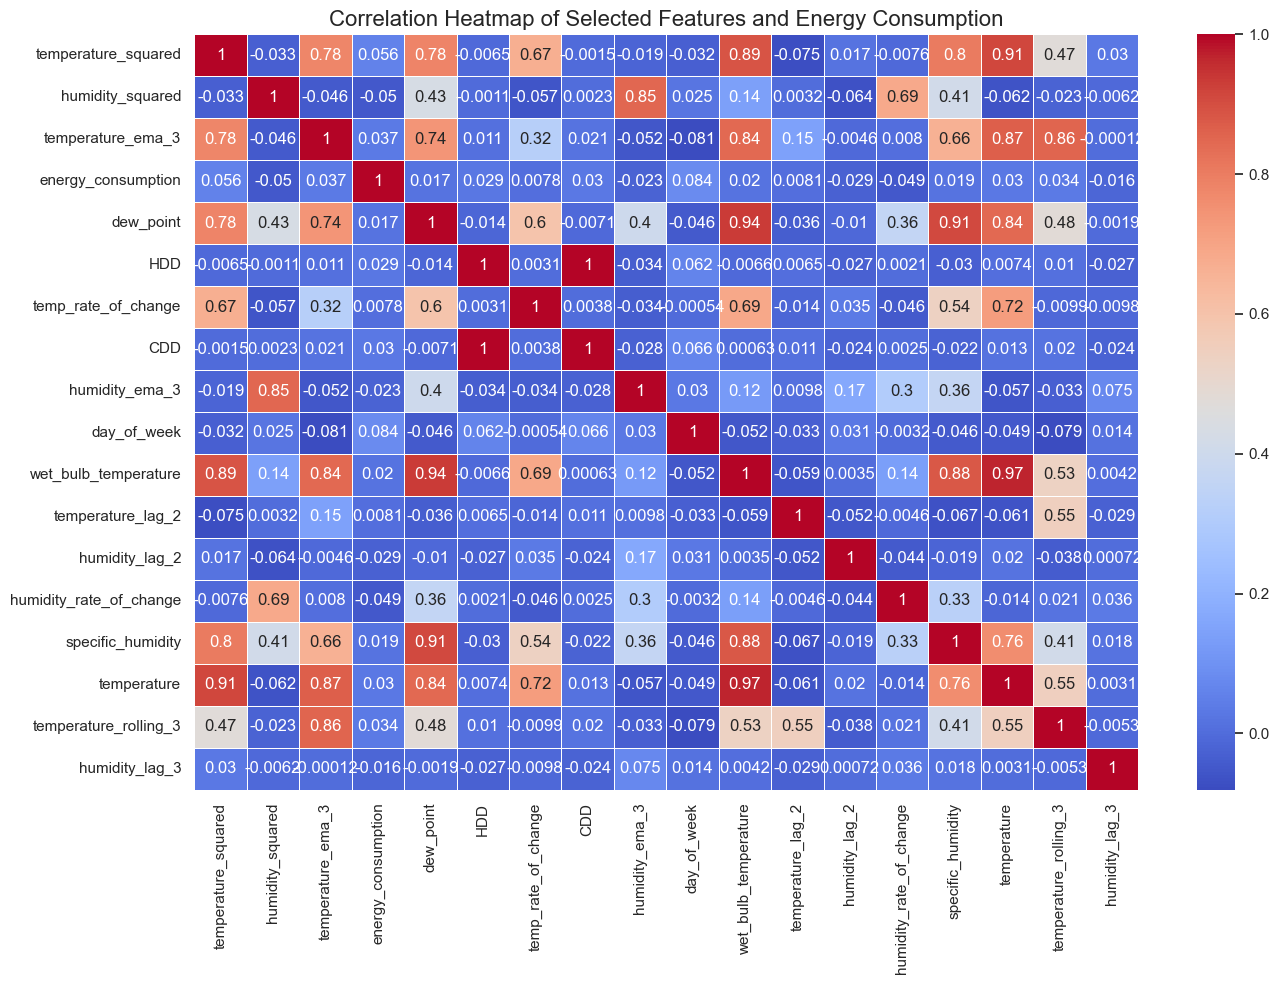

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def load_feature_eng_dataframe(file_name):
    """Load the feature-engineered DataFrame from a CSV file."""
    df_feature_eng = pd.read_csv(file_name, index_col=0, parse_dates=True)
    print(f"DataFrame loaded from {file_name}")
    
    # Reset the index to include the timestamp as a regular column and rename it
    df_feature_eng.reset_index(inplace=True)
    df_feature_eng.rename(columns={'index': 'timestamp'}, inplace=True)  # Rename index column
    
    return df_feature_eng

def plot_correlation_heatmap(df):
    """Plot correlation heatmap for all features and energy consumption."""
    # List of selected features including the corrected variables
    selected_features = [
        'temperature_squared', 'humidity_squared', 'temperature_ema_3', 'energy_consumption',
        'dew_point', 'HDD', 'temp_rate_of_change', 'CDD', 'humidity_ema_3', 'day_of_week',
        'wet_bulb_temperature', 'temperature_lag_2', 'humidity_lag_2', 'humidity_rate_of_change',
        'specific_humidity', 'temperature', 'temperature_rolling_3', 'humidity_lag_3'
    ]
    
    # Check if all selected features are present in the DataFrame
    available_features = [feature for feature in selected_features if feature in df.columns]
    
    # Calculate correlation matrix for the available features
    corr = df[available_features].corr()
    
    # Plot the correlation heatmap
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Heatmap of Selected Features and Energy Consumption', fontsize=16)
    plt.tight_layout()
    plt.show()

def main():
    # Load the feature-engineered DataFrame back into memory
    df = load_feature_eng_dataframe('df_feature_eng.csv')
    
    # Plot correlation heatmap
    plot_correlation_heatmap(df)

if __name__ == "__main__":
    main()


DataFrame loaded from df_feature_eng.csv


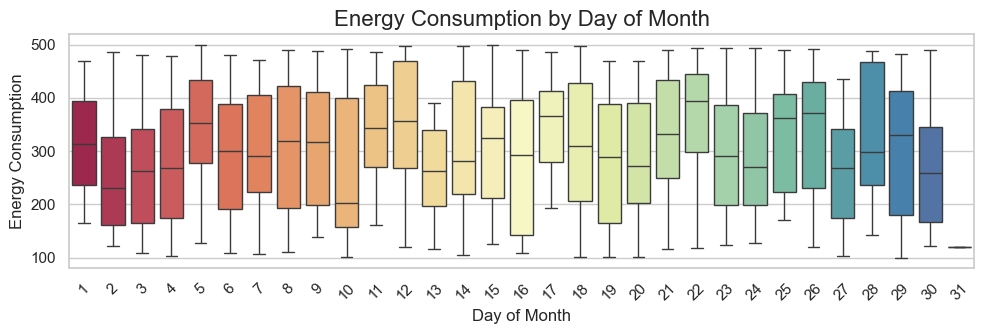

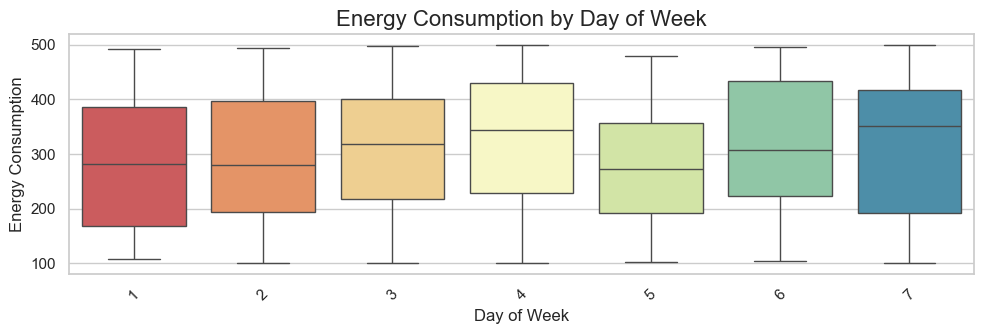

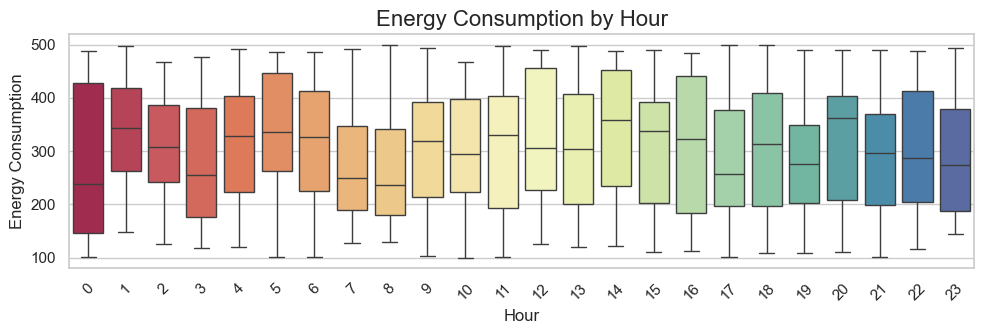

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def load_feature_eng_dataframe(file_name):
    """Load the feature-engineered DataFrame from a CSV file."""
    df_feature_eng = pd.read_csv(file_name, index_col=0, parse_dates=True)
    print(f"DataFrame loaded from {file_name}")
    
    # Reset the index to include the timestamp as a regular column and rename it
    df_feature_eng.reset_index(inplace=True)
    df_feature_eng.rename(columns={'index': 'timestamp'}, inplace=True)  # Rename index column
    
    return df_feature_eng

def plot_box_plots(df):
    """Plot box plots for all variables with int or int-like data types, excluding year and month."""
    # Loop through columns and find those with int data types, excluding 'year' and 'month'
    int_columns = df.select_dtypes(include=['int64', 'int32']).columns.tolist()
    
    # Exclude 'year', 'month', and 'day_of_year' columns
    int_columns = [col for col in int_columns if col not in ['year', 'month', 'day_of_year']]
    
    # Define order for specific columns
    day_of_week_order = [1, 2, 3, 4, 5, 6, 7]  # Monday to Sunday
    day_of_month_order = list(range(1, 32))  # Days of the month from 1 to 31
    
    for col in int_columns:
        if col == 'day_of_week':
            order = day_of_week_order
            col_label = 'Day of Week'
        elif col == 'day':
            order = day_of_month_order
            col_label = 'Day of Month'
        else:
            order = sorted(df[col].unique())  # Ensure natural order for other integer columns
            col_label = col.capitalize()
        
        plt.figure(figsize=(10, 3.5))
        
        # Using the x variable as hue and setting the correct order
        sns.boxplot(x=df[col].astype(str), y=df['energy_consumption'], palette="Spectral", order=[str(x) for x in order], dodge=False)
        plt.legend([], [], frameon=False)  # Hide legend
        
        plt.title(f'Energy Consumption by {col_label}', fontsize=16)
        plt.xlabel(f'{col_label}', fontsize=12)
        plt.ylabel('Energy Consumption', fontsize=12)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

def main():
    # Load the feature-engineered DataFrame back into memory
    df = load_feature_eng_dataframe('df_feature_eng.csv')
    
    # Plot box plots for all int-like columns, excluding year and month
    plot_box_plots(df)

if __name__ == "__main__":
    main()


### Standardization

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def load_feature_eng_dataframe(file_name):
    """Load the feature-engineered DataFrame from a CSV file."""
    df_feature_eng = pd.read_csv(file_name, index_col=0, parse_dates=True)
    print(f"DataFrame loaded from {file_name}")
    
    # Reset the index to include the timestamp as a regular column
    df_feature_eng.reset_index(inplace=True)
    
    return df_feature_eng

def standardize_data(df):
    """Standardize numerical features."""
    
    # Identify numerical columns
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Apply standardization
    scaler = StandardScaler()
    df[numeric_features] = scaler.fit_transform(df[numeric_features])
    
    return df

def main():
    # Load the feature-engineered DataFrame back into memory
    df = load_feature_eng_dataframe('df_feature_eng.csv')
    
    # Standardize the numerical data
    df_standardized = standardize_data(df)
    
    # Save the standardized DataFrame to a CSV file
    df_standardized.to_csv('df_standardized.csv', index=False)

    # Show the first few rows of the DataFrame after standardization (transposed for easier reading)
    print("\nFirst few rows of the DataFrame after standardization (transposed):")
    display(df_standardized.head().transpose())
    
    # # Display DataFrame info
    # print("\nDataFrame Info:")
    # display(df_standardized.info())

if __name__ == "__main__":
    main()


DataFrame loaded from df_feature_eng.csv

First few rows of the DataFrame after standardization (transposed):


,0,1,2,3,4
timestamp,2023-01-01 05:00:00,2023-01-01 06:00:00,2023-01-01 07:00:00,2023-01-01 08:00:00,2023-01-01 09:00:00
temperature,-0.871261,0.453713,-1.16324,-1.546219,1.601005
humidity,0.95657,0.266721,1.214107,-1.182765,0.674514
energy_consumption,0.534613,0.958305,1.408596,0.714597,-0.14784
year,0.0,0.0,0.0,0.0,0.0
month,0.0,0.0,0.0,0.0,0.0
day,-1.69773,-1.69773,-1.69773,-1.69773,-1.69773
day_of_week,1.458227,1.458227,1.458227,1.458227,1.458227
weekday,False,False,False,False,False
holiday,False,False,False,False,False
